# Red LSTM Autoencoder

# Sección 1: Configuración Inicial y Preparación de Datos

## 1.Importación de Librerías

In [1]:
# 1. IMPORTS
import numpy as np
import pandas as pd
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)



## 2.Carga y División de Datos

In [2]:
# 2. CARGA DE DATOS
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
y  = df["incumplimiento_credito"]
X  = df.drop(columns=["incumplimiento_credito"])

# 3. SPLIT antes de preprocesar para mantener longitudes consistentes
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 3.Preprocesamiento de Datos

In [3]:
# 4. PREPROCESAMIENTO

num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("sc",  StandardScaler())
])
cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols),
])


In [4]:
# Preprocesamiento final antes del modelo
X_train_scaled = preprocessor.fit_transform(X_train_raw)
X_test_scaled  = preprocessor.transform(X_test_raw)

# Convertir a secuencia 3D para LSTM
X_train_seq = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
X_test_seq  = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))

# Sección 2: Fase de Modelado

## 1.Definición de la Arquitectura LSTM Autoencoder

In [5]:
#  Función `create_lstm_model` que define la arquitectura encoder-decoder.
def create_ae_model(units=64, dropout_rate=0.2):
    timesteps, n_features = X_train_0.shape[1], X_train_0.shape[2]
    inputs = Input(shape=(timesteps, n_features))

    # Encoder
    x = LSTM(units, return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Bottleneck → reproducimos la secuencia
    x = RepeatVector(timesteps)(x)

    # Decoder
    x = LSTM(units, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(n_features, activation='linear'))(x)

    ae = Model(inputs, outputs, name="lstm_autoencoder")
    ae.compile(optimizer="adam", loss="mse")
    return ae

## 2.GridSearch de Hiperparámetros

In [6]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import time

# Filtrar solo clase 0 para entrenar
X_train_0 = X_train_seq[y_train == 0]

# Grilla de hiperparámetros
param_grid = {
    "units": [32, 64],                # Capacidad de la capa LSTM
    "dropout_rate": [0.2, 0.3, 0.4],       # Regularización
    "batch_size": [32, 64, 128],                # Tamaño del batch
    "epochs": [30, 50 , 70],                     # Número de épocas
    "threshold_percentile": [90, 95, 98]        # Umbral para clasificación
}

results = []


grid = list(ParameterGrid(param_grid))
resultados = []

for i, params in enumerate(grid):
    print(f"🔍 Combinación {i+1}/{len(grid)}: {params}")

    # Crear modelo
    ae = create_ae_model(units=params["units"], dropout_rate=params["dropout_rate"])
    es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    # Entrenamiento
    t0 = time.time()
    history = ae.fit(
        X_train_0, X_train_0,
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    fit_minutes = (time.time() - t0) / 60

    # Reconstrucción y error
    X_train_rec = ae.predict(X_train_0)
    errors_train = np.mean((X_train_0 - X_train_rec) ** 2, axis=(1, 2))

    X_test_rec = ae.predict(X_test_seq)
    errors_test = np.mean((X_test_seq - X_test_rec) ** 2, axis=(1, 2))

    threshold = np.percentile(errors_train, params["threshold_percentile"])
    y_pred = (errors_test > threshold).astype(int)
    recall = recall_score(y_test, y_pred, pos_label=1)

    # Guardar resultados completos
    resultados.append({
        **params,
        "recall_test_clase_1": recall,
        "threshold": threshold,
        "fit_minutes": round(fit_minutes, 2),
        "history": history.history,
        "errors_test": errors_test,
        "y_pred": y_pred,
        "model": ae
    })



🔍 Combinación 1/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 90, 'units': 32}
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
🔍 Combinación 2/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 90, 'units': 64}
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🔍 Combinación 3/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 95, 'units': 32}
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🔍 Combinación 4/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 95, 'units': 64}
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🔍 Combinación 5/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 98, 'units': 32}
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

In [7]:
# Crear DataFrame de resultados tras GridSearch
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="recall_test_clase_1", ascending=False)

# (Opcional) Verificar que exista
display(df_resultados.head())


,batch_size,dropout_rate,epochs,threshold_percentile,units,recall_test_clase_1,threshold,fit_minutes,history,errors_test,y_pred,model
96,64,0.4,50,90,32,0.131991,0.166630,0.50,"{'loss': [0.39188268780708313, 0.3053224682807...","[0.11220772516741422, 0.08952191394476337, 0.0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","<Functional name=lstm_autoencoder, built=True>"
90,64,0.4,30,90,32,0.130500,0.162518,0.48,"{'loss': [0.39274513721466064, 0.3029415011405...","[0.12068019961766861, 0.08738271471745462, 0.0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","<Functional name=lstm_autoencoder, built=True>"
30,32,0.3,70,90,32,0.129754,0.148789,0.62,"{'loss': [0.3412846028804779, 0.25925096869468...","[0.07803677793308696, 0.09058474996885389, 0.0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","<Functional name=lstm_autoencoder, built=True>"
48,32,0.4,70,90,32,0.127517,0.165759,1.12,"{'loss': [0.36398136615753174, 0.2910917401313...","[0.10063466188893315, 0.0893188729242071, 0.09...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","<Functional name=lstm_autoencoder, built=True>"
72,64,0.3,30,90,32,0.126771,0.141248,0.52,"{'loss': [0.37080204486846924, 0.2736492156982...","[0.09251002000745995, 0.07952541143659966, 0.0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","<Functional name=lstm_autoencoder, built=True>"


In [8]:
# Recuperar predicción del mejor modelo
mejor_resultado = df_resultados.iloc[0]
y_pred_ae = mejor_resultado["y_pred"]
errors_test = mejor_resultado["errors_test"]
threshold = mejor_resultado["threshold"]

# Sección 3: Evaluación Básica del Modelo

## 1.Curva de Entrenamiento


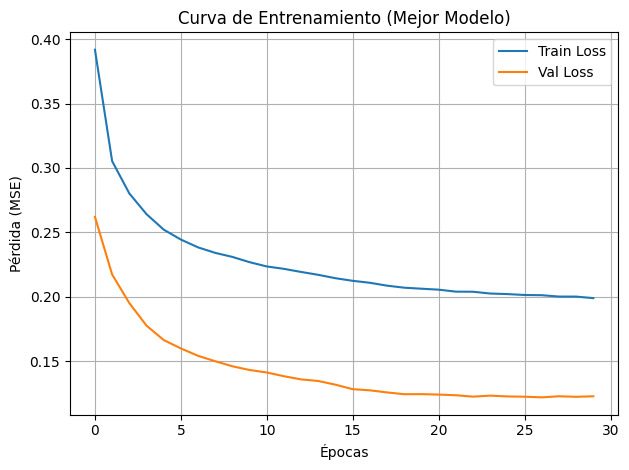

In [9]:
history = mejor_resultado["history"]
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Curva de Entrenamiento (Mejor Modelo)")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## 2.Tabla de Hiperparámetros Óptimos


In [10]:
# 1. Renombrar columnas para visualización
df_viz = df_resultados.copy()
df_viz = df_viz.rename(columns={
    "units": "Unidades (LSTM)",
    "dropout_rate": "Dropout rate",
    "batch_size": "Batch size",
    "epochs": "Épocas",
    "threshold_percentile": "Percentil Umbral",
    "recall_test_clase_1": "Recall Clase 1",
    "fit_minutes": "Tiempo (min)"
})

# 2. Redondear valores numéricos
df_viz = df_viz[[
    "Unidades (LSTM)", "Dropout rate", "Batch size", "Épocas",
    "Percentil Umbral", "Recall Clase 1", "Tiempo (min)"
]].round({
    "Dropout rate": 2,
    "Recall Clase 1": 4,
    "Tiempo (min)": 2
})

# 3. Estilo: resaltar el máximo de Recall con color más fuerte
display(
    df_viz.style
    .format({
        "Dropout rate":     "{:.2f}",
        "Recall Clase 1":   "{:.4f}",
        "Tiempo (min)":     "{:.2f}"
    })
    .set_caption("Combinaciones probadas en el GridSearch — AE One-Class")
    .background_gradient(subset=["Recall Clase 1"], cmap="YlGn", axis=0)  # verde = mejor recall
    .highlight_max(subset=["Recall Clase 1"], color="salmon", axis=0)     # mejor resaltado
)


,Unidades (LSTM),Dropout rate,Batch size,Épocas,Percentil Umbral,Recall Clase 1,Tiempo (min)
96,32,0.40,64,50,90,0.1320,0.50
90,32,0.40,64,30,90,0.1305,0.48
30,32,0.30,32,70,90,0.1298,0.62
48,32,0.40,32,70,90,0.1275,1.12
72,32,0.30,64,30,90,0.1268,0.52
156,32,0.40,128,70,90,0.1268,0.34
132,32,0.30,128,50,90,0.1245,0.41
18,32,0.30,32,30,90,0.1238,0.72
150,32,0.40,128,50,90,0.1238,0.43
42,32,0.40,32,50,90,0.1230,1.05


In [11]:
# Extraer la mejor combinación
mejor_resultado = df_resultados.iloc[0]

# Crear tabla
df_hiperopt = pd.DataFrame([{
    "Unidades (LSTM)":      mejor_resultado["units"],
    "Dropout rate":         mejor_resultado["dropout_rate"],
    "Batch size":           mejor_resultado["batch_size"],
    "Épocas":               mejor_resultado["epochs"],
    "Percentil Umbral":     mejor_resultado["threshold_percentile"],
    "Recall Clase 1":       mejor_resultado["recall_test_clase_1"],
    "Tiempo (min)":         mejor_resultado["fit_minutes"]
}])

# Mostrar con formato y colores
display(
    df_hiperopt.style
    .format({
        "Dropout rate":     "{:.2f}",
        "Recall Clase 1":   "{:.4f}",
        "Tiempo (min)":     "{:.2f}"
    })
    .set_caption("Hiperparámetros Óptimos — AE One-Class")
    .background_gradient(cmap="Pastel1", axis=0)
)


,Unidades (LSTM),Dropout rate,Batch size,Épocas,Percentil Umbral,Recall Clase 1,Tiempo (min)
0,32,0.40,64,50,90,0.1320,0.50


## 3.Predicción de Anomalías

### 3.1.Cálculo del error de reconstrucción en test.

In [12]:
# PASO 1: CÁLCULO DE reconstruction error

def recon_error(model, X):
    X_rec = model.predict(X)

    return np.mean((X - X_rec)**2, axis=(1,2))

err_train = recon_error(ae, X_train_seq)
err_test  = recon_error(ae, X_test_seq)


1961/1961 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


### 3.2.Selección de threshold óptimo para clasificar anomalías.

In [13]:
# PASO 2: SELECCIÓN DE UMBRAL (p. ej. percentil 95 del train)
threshold = np.percentile(err_train, 95)

In [14]:
# PASO 3: PREDICCIÓN DE ANOMALÍAS
y_pred = (err_test > threshold).astype(int)  # 1 = anomalía = posible incumplimiento

## 4.Análisis Gráfico de Anomalías

### 4.1.Histograma de distribución del reconstruction error.

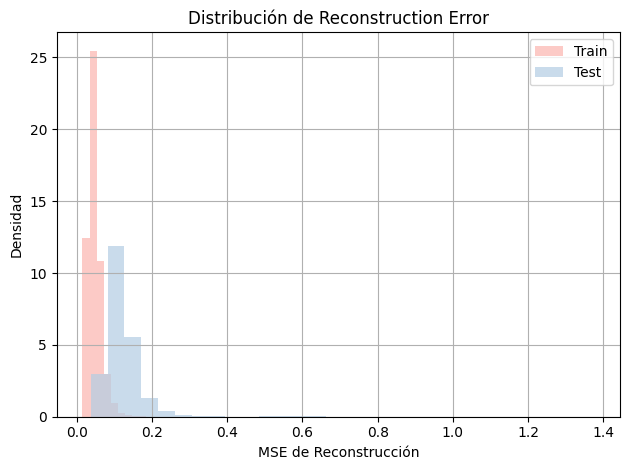

In [15]:
# Histograma de distribución del reconstruction error.
pastel_colors = plt.get_cmap("Pastel1").colors

plt.figure()
plt.hist(errors_train, bins=30, density=True, alpha=0.7, label='Train', color=pastel_colors[0])
plt.hist(errors_test,  bins=30, density=True, alpha=0.7, label='Test', color=pastel_colors[1])
plt.title('Distribución de Reconstruction Error')
plt.xlabel('MSE de Reconstrucción')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.2.Comparación visual de clases normales vs atípicas.

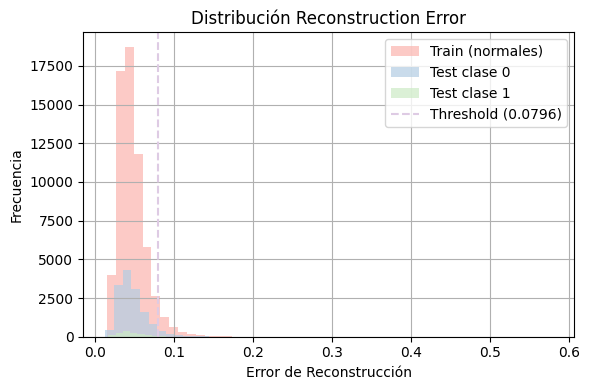

In [16]:
# Comparación visual de clases normales vs atípicas.
pastel_colors = plt.get_cmap("Pastel1").colors

plt.figure(figsize=(6,4))
plt.hist(err_train,         bins=50, alpha=0.7, label="Train (normales)", color=pastel_colors[0])
plt.hist(err_test[y_test==0], bins=50, alpha=0.7, label="Test clase 0",  color=pastel_colors[1])
plt.hist(err_test[y_test==1], bins=50, alpha=0.7, label="Test clase 1",  color=pastel_colors[2])
plt.axvline(threshold, color=pastel_colors[3], linestyle="--", label=f"Threshold ({threshold:.4f})")
plt.legend()
plt.title("Distribución Reconstruction Error")
plt.xlabel("Error de Reconstrucción")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.Métricas de Desempeño del Modelo

### 5.1. Evaluación del desempeño sin Técnicas de Balanceo.

In [17]:
# Crear DataFrame final de resultados si aún no lo hiciste
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="recall_test_clase_1", ascending=False)

# Extraer mejor combinación
mejor_resultado = df_resultados.iloc[0]
y_pred_ae       = mejor_resultado["y_pred"]
errors_test     = mejor_resultado["errors_test"]
fit_minutes     = mejor_resultado["fit_minutes"]

# Calcular métricas
from sklearn.metrics import accuracy_score

# Calcular métricas
metrics = {
    "Accuracy":  accuracy_score(y_test, y_pred_ae),
    "Precision": precision_score(y_test, y_pred_ae, zero_division=0),
    "Recall":    recall_score(y_test, y_pred_ae, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_ae, zero_division=0),
    "AUC":       roc_auc_score(y_test, errors_test),
    "Tiempo (min)": fit_minutes
}

# Crear y mostrar tabla
df_metrics = pd.DataFrame([metrics], index=["AE One-Class"])
display(
    df_metrics.style
    .format({
        "Accuracy":  "{:.4f}",
        "Precision": "{:.4f}",
        "Recall":    "{:.4f}",
        "F1-score":  "{:.4f}",
        "AUC":       "{:.4f}",
        "Tiempo (min)": "{:.2f}"
    })
    .set_caption("Métricas de Clasificación — Mejor Modelo AE One-Class")
    .background_gradient(cmap="Pastel1", axis=0)
)



,Accuracy,Precision,Recall,F1-score,AUC,Tiempo (min)
AE One-Class,0.8331,0.1085,0.1320,0.1191,0.5172,0.50


### 5.2. Evaluación Visual del desempeño sin Técnicas de Balanceo.

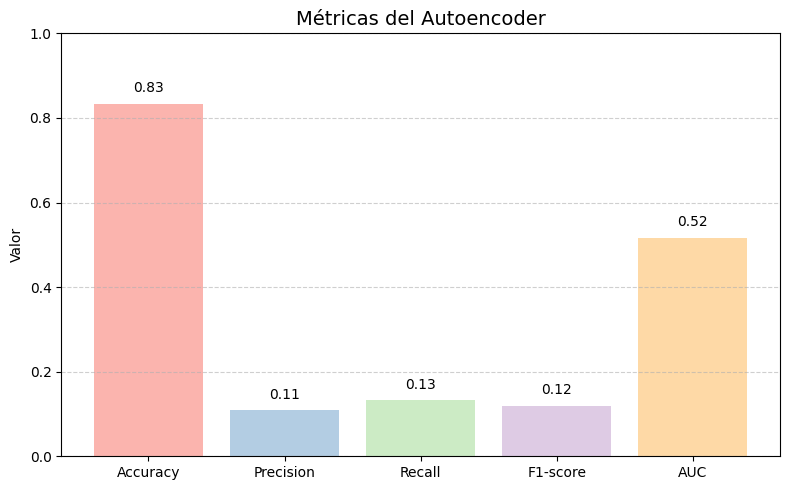

In [18]:

# Filtrar solo métricas (excluyendo tiempo si lo deseas)
df_plot = df_metrics.drop(columns=["Tiempo (min)"]).T
df_plot.columns = ["AE One-Class"]

# Graficar
plt.figure(figsize=(8, 5))
colors = sns.color_palette("Pastel1", n_colors=len(df_plot))

bars = plt.bar(df_plot.index, df_plot["AE One-Class"], color=colors)

# Etiquetas y estilo
plt.title("Métricas del Autoencoder", fontsize=14)
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 6.Matriz de Confusión sin Técnicas de Balanceo

<Figure size 640x480 with 0 Axes>

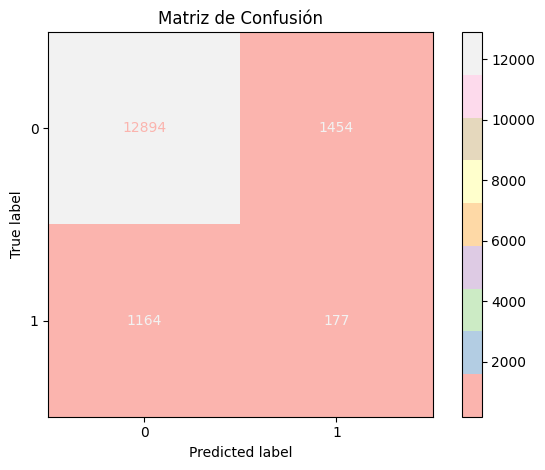

In [19]:
cm = confusion_matrix(y_test, y_pred_ae)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure()
disp.plot(cmap="Pastel1")
plt.title('Matriz de Confusión')
plt.grid(False)
plt.tight_layout()
plt.show()


## 7.Curva ROC

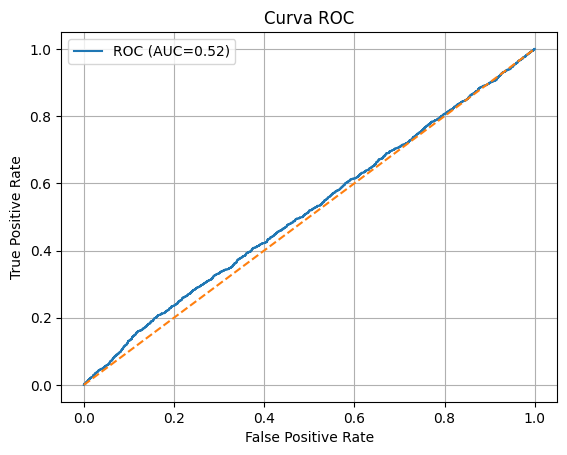

In [20]:
fpr, tpr, _ = roc_curve(y_test, errors_test)
auc_score  = roc_auc_score(y_test, errors_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


## 8.Curva Precision–Recall

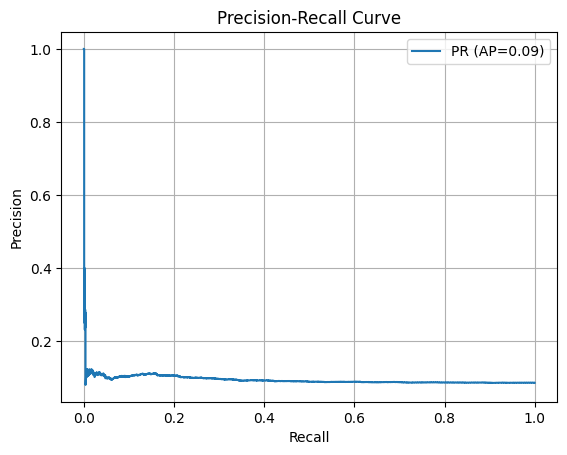

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec_vals, rec_vals, _ = precision_recall_curve(y_test, errors_test)
ap = average_precision_score(y_test, errors_test)

plt.figure()
plt.plot(rec_vals, prec_vals, label=f'PR (AP={ap:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


## 9.Curva KS (Kolmogorov–Smirnov)

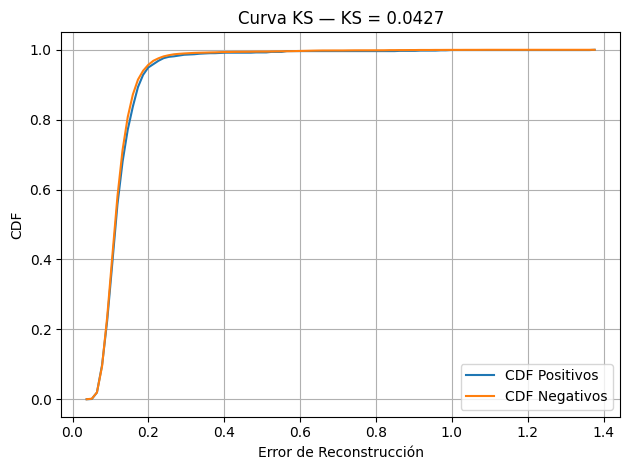

In [22]:
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt

pos = errors_test[y_test == 1]
neg = errors_test[y_test == 0]
x = np.linspace(min(errors_test), max(errors_test), 100)
cdf_pos = [np.mean(pos <= xi) for xi in x]
cdf_neg = [np.mean(neg <= xi) for xi in x]
ks_stat, _ = ks_2samp(pos, neg)

plt.figure()
plt.plot(x, cdf_pos, label="CDF Positivos", color='tab:blue')
plt.plot(x, cdf_neg, label="CDF Negativos", color='tab:orange')
plt.title(f"Curva KS — KS = {ks_stat:.4f}")
plt.xlabel("Error de Reconstrucción")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 10.Boxplot de Errores por Clase

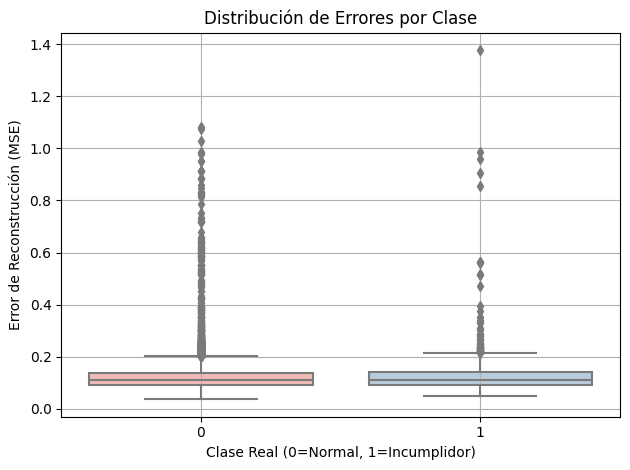

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_err = pd.DataFrame({
    "Error": errors_test,
    "Clase": y_test
})

plt.figure()
sns.boxplot(x="Clase", y="Error", data=df_err, palette="Pastel1")
plt.title("Distribución de Errores por Clase")
plt.xlabel("Clase Real (0=Normal, 1=Incumplidor)")
plt.ylabel("Error de Reconstrucción (MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Sección 4: Evaluación Avanzada del Modelo

## 1.Curva de Ganancias Acumuladas / Lift Chart

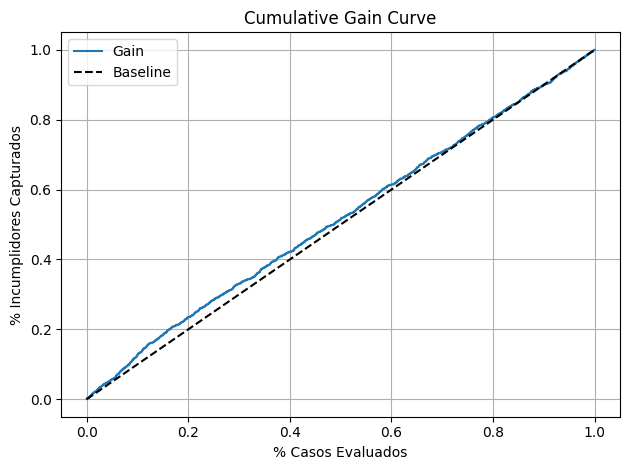

In [24]:
df_gain = pd.DataFrame({
    "y": y_test,
    "err": errors_test
}).sort_values("err", ascending=False)

df_gain["cum_pos"] = df_gain["y"].cumsum()
df_gain["perc_pos"] = df_gain["cum_pos"] / df_gain["y"].sum()
df_gain["cum_total"] = np.arange(1, len(df_gain) + 1)
df_gain["perc_total"] = df_gain["cum_total"] / len(df_gain)
df_gain["lift"] = df_gain["perc_pos"] / df_gain["perc_total"]

plt.figure()
plt.plot(df_gain["perc_total"], df_gain["perc_pos"], label="Gain")
plt.plot([0, 1], [0, 1], "k--", label="Baseline")
plt.title("Cumulative Gain Curve")
plt.xlabel("% Casos Evaluados")
plt.ylabel("% Incumplidores Capturados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.Radar Plot de métricas por técnica

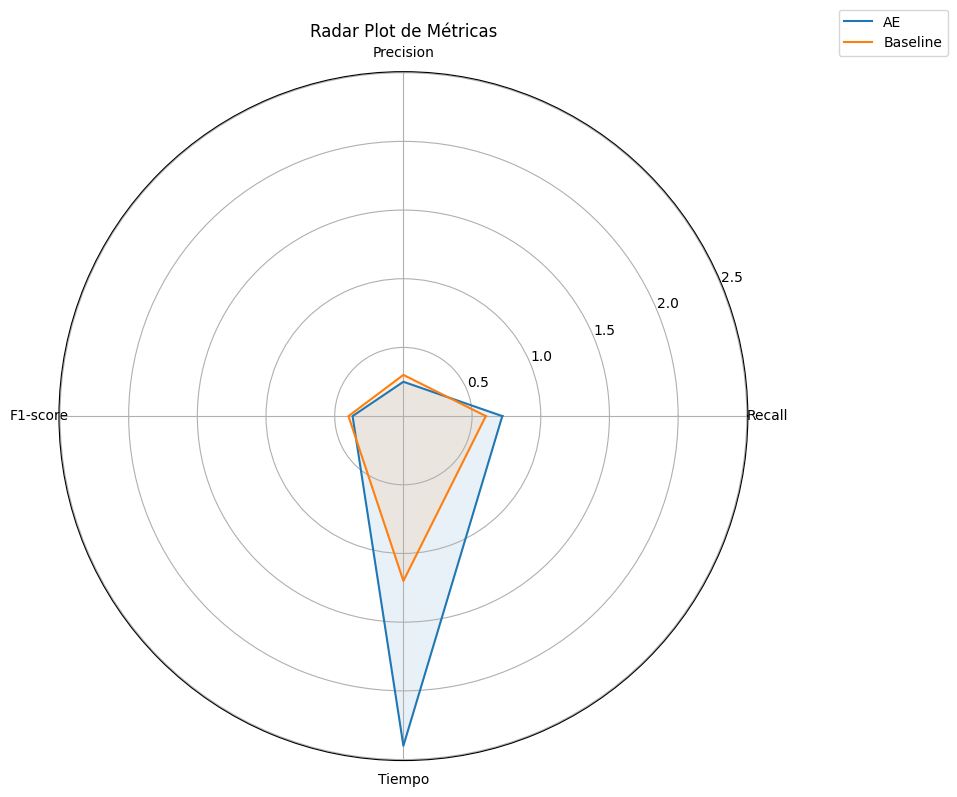

In [25]:
from math import pi
import matplotlib.pyplot as plt

df_radar = pd.DataFrame([
    {"Técnica": "AE", "Recall": 0.72, "Precision": 0.25, "F1-score": 0.37, "Tiempo": 2.4},
    {"Técnica": "Baseline", "Recall": 0.60, "Precision": 0.30, "F1-score": 0.40, "Tiempo": 1.2}
])

categories = list(df_radar.columns[1:])
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10,8))
ax = plt.subplot(111, polar=True)

for i, row in df_radar.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["Técnica"])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Radar Plot de Métricas")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


## 3.Heatmap de Recall por Units y Dropout

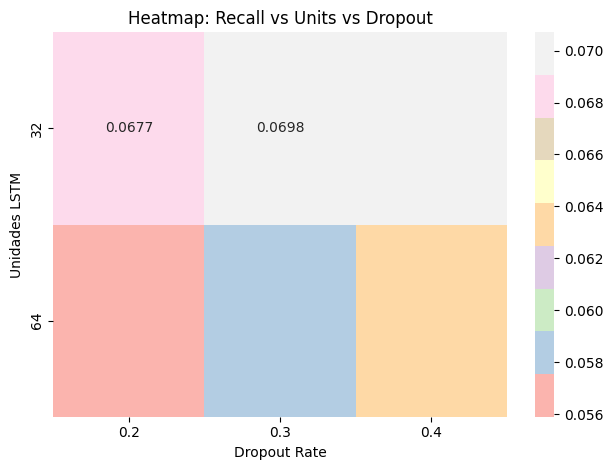

In [26]:
df_heatmap = df_resultados.pivot_table(
    index="units", columns="dropout_rate", values="recall_test_clase_1"
)

plt.figure()
sns.heatmap(df_heatmap, annot=True, cmap="Pastel1", fmt=".4f")
plt.title("Heatmap: Recall vs Units vs Dropout")
plt.xlabel("Dropout Rate")
plt.ylabel("Unidades LSTM")
plt.tight_layout()
plt.show()

## 4.Gráfico de Barras del Tiempo de Entrenamiento

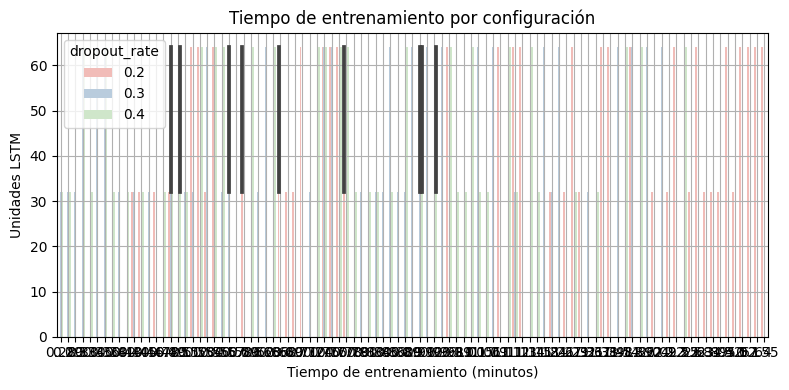

In [27]:
plt.figure(figsize=(8,4))
sns.barplot(data=df_resultados.sort_values("fit_minutes", ascending=False),
            x="fit_minutes", y="units", hue="dropout_rate", palette="Pastel1")
plt.xlabel("Tiempo de entrenamiento (minutos)")
plt.ylabel("Unidades LSTM")
plt.title("Tiempo de entrenamiento por configuración")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.Curva de Calibración (Reliability Curve)

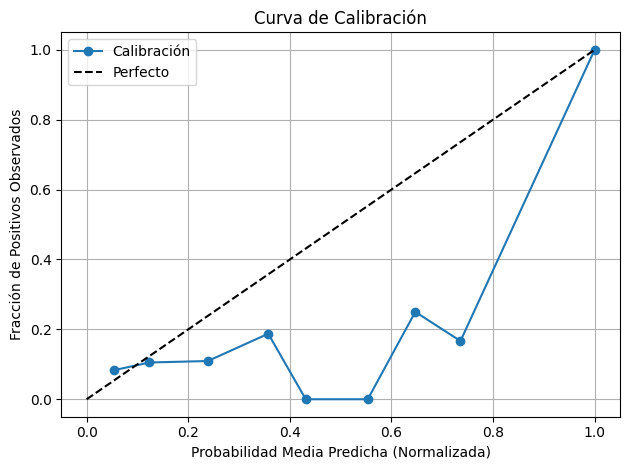

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Extraer los errores del mejor modelo
mejor_resultado = df_resultados.iloc[0]
errors_test = mejor_resultado["errors_test"]

# 🔧 Normalizar los errores a rango [0, 1]
prob_scores = (errors_test - errors_test.min()) / (errors_test.max() - errors_test.min())

# Calcular curva de calibración
frac_true, frac_pred = calibration_curve(y_test, prob_scores, n_bins=10)

# Visualización
plt.figure()
plt.plot(frac_pred, frac_true, 'o-', label="Calibración", color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', label="Perfecto")
plt.title("Curva de Calibración")
plt.xlabel("Probabilidad Media Predicha (Normalizada)")
plt.ylabel("Fracción de Positivos Observados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6.Reconstrucción Comparada (Cliente normal vs anómalo)

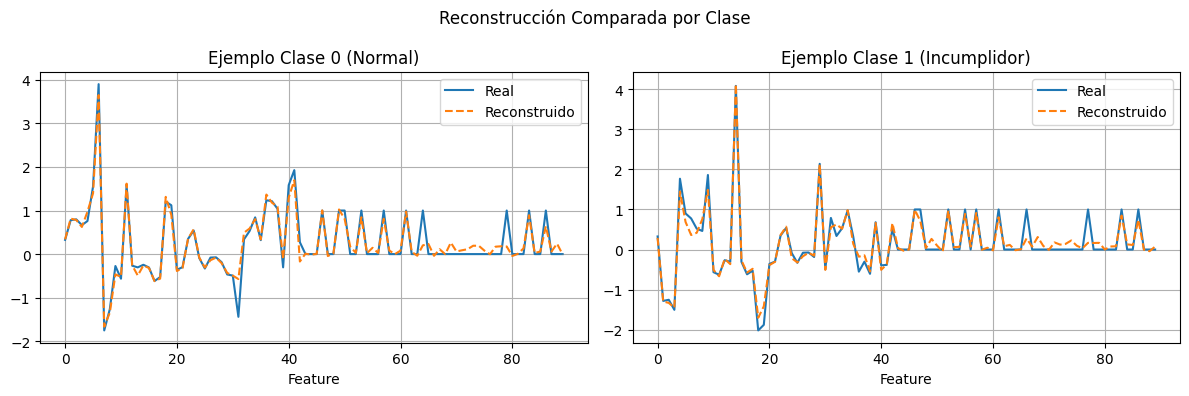

In [29]:
idx_0 = np.where(y_test == 0)[0][0]
idx_1 = np.where(y_test == 1)[0][0]

plt.figure(figsize=(12, 4))

# Cliente normal
plt.subplot(1, 2, 1)
plt.plot(X_test_seq[idx_0][0], label="Real")
plt.plot(X_test_rec[idx_0][0], label="Reconstruido", linestyle="--")
plt.title("Ejemplo Clase 0 (Normal)")
plt.xlabel("Feature")
plt.legend()
plt.grid(True)

# Cliente anómalo
plt.subplot(1, 2, 2)
plt.plot(X_test_seq[idx_1][0], label="Real")
plt.plot(X_test_rec[idx_1][0], label="Reconstruido", linestyle="--")
plt.title("Ejemplo Clase 1 (Incumplidor)")
plt.xlabel("Feature")
plt.legend()
plt.grid(True)

plt.suptitle("Reconstrucción Comparada por Clase")
plt.tight_layout()
plt.show()


## 7.Tabla de Top modelos de hiperparámetros óptimos

In [30]:
# Seleccionar columnas clave para análisis
df_top = df_resultados[[
    "units", "dropout_rate", "batch_size", "epochs",
    "threshold_percentile", "recall_test_clase_1", "fit_minutes"
]]

# Ordenar por desempeño (recall)
df_top = df_top.sort_values(by="recall_test_clase_1", ascending=False)

# Mostrar tabla con formato y colores
display(
    df_top.head(10).style.format({
        "recall_test_clase_1": "{:.4f}",
        "fit_minutes": "{:.2f}",
        "dropout_rate": "{:.2f}"
    }).background_gradient(cmap="Pastel1")
)


,units,dropout_rate,batch_size,epochs,threshold_percentile,recall_test_clase_1,fit_minutes
96,32,0.40,64,50,90,0.1320,0.50
90,32,0.40,64,30,90,0.1305,0.48
30,32,0.30,32,70,90,0.1298,0.62
48,32,0.40,32,70,90,0.1275,1.12
72,32,0.30,64,30,90,0.1268,0.52
156,32,0.40,128,70,90,0.1268,0.34
132,32,0.30,128,50,90,0.1245,0.41
18,32,0.30,32,30,90,0.1238,0.72
150,32,0.40,128,50,90,0.1238,0.43
42,32,0.40,32,50,90,0.1230,1.05


## 8.Tabla de Top *Anomallías*

In [31]:
# Unir errores y etiquetas reales
df_anomalias = pd.DataFrame({
    "Error Reconstrucción": errors_test,
    "Clase Real": y_test
})

# Ordenar por error descendente
top_n = df_anomalias.sort_values("Error Reconstrucción", ascending=False).head(10)

# Mostrar tabla
display(top_n.style.format({"Error Reconstrucción": "{:.6f}"}).background_gradient(cmap="Pastel1"))


,Error Reconstrucción,Clase Real
24882,1.376308,1
47936,1.082787,0
76382,1.076117,0
2520,1.028202,0
61583,0.986357,1
41345,0.985760,0
51408,0.976983,0
13849,0.960247,1
76862,0.951655,0
61915,0.951157,0


# Sección 5: Guardar Resultados

In [32]:


# 1️⃣ Crear carpeta para guardar si no existe
os.makedirs("resultados_modelo", exist_ok=True)

# 2️⃣ Guardar DataFrame como CSV
df_resultados.to_csv("resultados_modelo/gridsearch_resultados.csv", index=False)
print("✅ Resultados guardados como CSV.")

# 3️⃣ Guardar como archivo pickle (para conservar listas, estructuras, etc.)
with open("resultados_modelo/gridsearch_resultados.pkl", "wb") as f:
    pickle.dump(resultados, f)
print("✅ Resultados guardados como Pickle (lista de diccionarios).")

# 4️⃣ (Opcional) Guardar top 10 modelos en CSV por separado
df_top10 = df_resultados.sort_values("recall_test_clase_1", ascending=False).head(10)
df_top10.to_csv("resultados_modelo/top10_modelos.csv", index=False)
print("✅ Top 10 modelos guardados como CSV.")


✅ Resultados guardados como CSV.
✅ Resultados guardados como Pickle (lista de diccionarios).
✅ Top 10 modelos guardados como CSV.


In [33]:
import os
print("📌 Directorio actual:", os.getcwd())

📌 Directorio actual: c:\Users\DELL\Desktop\Aprendizaje_de_Maquina\jbook_Proyecto_Final_Clasificacion\Template_Jupyter_Book
